In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

window_size = 1_000_000  

fai_path = Path("Danio_rerio.fasta.fai")
te_path = Path("Danio_rerio_TE_table.tsv")
out_path = Path("Danio_rerio_TE_density_1Mb.tsv")


fai = pd.read_csv(
    fai_path,
    sep="\t",
    header=None,
    names=["chrom", "length", "offset", "line_bases", "line_width"]
)

fai = fai[fai["chrom"].str.startswith("NC_")].copy()

te = pd.read_csv(te_path, sep="\t")

te = te[te["chrom"].isin(fai["chrom"])].copy()

records = []

for _, row in fai.iterrows():
    chrom = row["chrom"]
    chr_len = int(row["length"])

    # Number of windows for this chromosome
    n_win = int(np.ceil(chr_len / window_size))

    te_chr = te[te["chrom"] == chrom]

    # Arrays for TE bp and TE counts per window
    te_bp = np.zeros(n_win, dtype=np.int64)
    te_count = np.zeros(n_win, dtype=np.int64)

    for _, t in te_chr.iterrows():
        start = int(t["start"])
        end = int(t["end"])

        # Convert to 0-based half-open for easier math
        s0 = start - 1
        e0 = end  # inclusive in GFF => half-open [s0, e0)

        first_win = s0 // window_size
        last_win = (e0 - 1) // window_size

        # Add bp coverage to all windows this TE overlaps
        for w in range(first_win, last_win + 1):
            win_start = w * window_size
            win_end = min((w + 1) * window_size, chr_len)
            overlap_start = max(s0, win_start)
            overlap_end = min(e0, win_end)
            if overlap_end > overlap_start:
                te_bp[w] += (overlap_end - overlap_start)

        # Count this TE once in the window where its midpoint falls
        mid = (s0 + e0) // 2
        w_mid = mid // window_size
        if 0 <= w_mid < n_win:
            te_count[w_mid] += 1

    # Emit one record per window for this chromosome
    for w in range(n_win):
        win_start = w * window_size + 1  # back to 1-based inclusive
        win_end = min((w + 1) * window_size, chr_len)
        win_len = win_end - win_start + 1
        frac = te_bp[w] / win_len if win_len > 0 else 0.0

        records.append({
            "chrom": chrom,
            "window_index": w,
            "window_start": win_start,
            "window_end": win_end,
            "window_size": win_len,
            "te_bp": int(te_bp[w]),
            "te_fraction": frac,
            "te_count": int(te_count[w])
        })

dfw = pd.DataFrame.from_records(records)
dfw.to_csv(out_path, sep="\t", index=False)
print("Wrote", out_path, "with", len(dfw), "windows")


Wrote Danio_rerio_TE_density_1Mb.tsv with 1362 windows


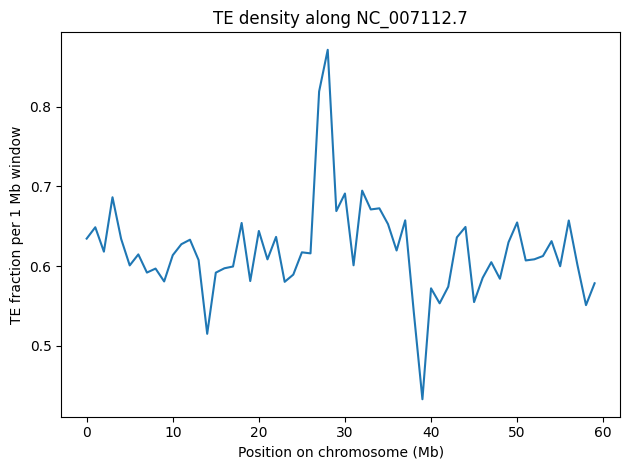

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

dfw = pd.read_csv("Danio_rerio_TE_density_1Mb.tsv", sep="\t")

# Pick one chromosome, e.g. NC_007112.7
chr_id = "NC_007112.7"
dfc = dfw[dfw["chrom"] == chr_id].sort_values("window_start")

plt.figure()
plt.plot(dfc["window_start"] / 1e6, dfc["te_fraction"])
plt.xlabel("Position on chromosome (Mb)")
plt.ylabel("TE fraction per 1 Mb window")
plt.title(f"TE density along {chr_id}")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
from pathlib import Path

# Parse GFF3 to extract genes
gff_path = Path("Danio_rerio.GRCz11.115.gff3")

# Create mapping: chromosome number -> NC_ accession
# Based on the order in your fai file (NC_007112.7 is chr1, NC_007113.7 is chr2, etc.)
chr_mapping = {
    "1": "NC_007112.7",
    "2": "NC_007113.7",
    "3": "NC_007114.7",
    "4": "NC_007115.7",
    "5": "NC_007116.7",
    "6": "NC_007117.7",
    "7": "NC_007118.7",
    "8": "NC_007119.7",
    "9": "NC_007120.7",
    "10": "NC_007121.7",
    "11": "NC_007122.7",
    "12": "NC_007123.7",
    "13": "NC_007124.7",
    "14": "NC_007125.7",
    "15": "NC_007126.7",
    "16": "NC_007127.7",
    "17": "NC_007128.7",
    "18": "NC_007129.7",
    "19": "NC_007130.7",
    "20": "NC_007131.7",
    "21": "NC_007132.7",
    "22": "NC_007133.7",
    "23": "NC_007134.7",
    "24": "NC_007135.7",
    "25": "NC_007136.7",
    # "MT": "NC_002333.2"  # mitochondrial
}

# Read GFF3, skip comments
genes = []
with open(gff_path) as f:
    for line in f:
        if line.startswith("#"):
            continue
        fields = line.strip().split("\t")
        if len(fields) < 9:
            continue
        
        seqid, source, feature_type, start, end, score, strand, phase, attrs = fields
        
        # Keep only gene features (not exons, CDS, etc.)
        if feature_type == "gene":
            # Map chromosome number to NC_ accession
            nc_chrom = chr_mapping.get(seqid)
            if nc_chrom:  # Only keep chromosomes we have in our mapping
                genes.append({
                    "chrom": nc_chrom,
                    "start": int(start),
                    "end": int(end),
                    "strand": strand,
                    "length": int(end) - int(start) + 1
                })

genes_df = pd.DataFrame(genes)

print(f"Loaded {len(genes_df)} genes")
genes_df.head()

Loaded 25268 genes


,chrom,start,end,strand,length
0,NC_007112.7,6408,12027,-,5620
1,NC_007112.7,11822,16373,+,4552
2,NC_007112.7,18716,23389,+,4674
3,NC_007112.7,25585,27255,+,1671
4,NC_007112.7,27690,34330,+,6641


In [13]:
# Now calculate gene density using the same sliding window approach
window_size = 1_000_000

fai_path = Path("Danio_rerio.fasta.fai")
out_path = Path("Danio_rerio_gene_density_1Mb.tsv")

fai = pd.read_csv(
    fai_path,
    sep="\t",
    header=None,
    names=["chrom", "length", "offset", "line_bases", "line_width"]
)

fai = fai[fai["chrom"].str.startswith("NC_")].copy()

records = []

for _, row in fai.iterrows():
    chrom = row["chrom"]
    chr_len = int(row["length"])
    n_win = int(np.ceil(chr_len / window_size))
    
    genes_chr = genes_df[genes_df["chrom"] == chrom]
    
    gene_bp = np.zeros(n_win, dtype=np.int64)
    gene_count = np.zeros(n_win, dtype=np.int64)
    
    for _, g in genes_chr.iterrows():
        start = int(g["start"])
        end = int(g["end"])
        
        # Convert to 0-based half-open
        s0 = start - 1
        e0 = end
        
        first_win = s0 // window_size
        last_win = (e0 - 1) // window_size
        
        # Add bp coverage
        for w in range(first_win, last_win + 1):
            win_start = w * window_size
            win_end = min((w + 1) * window_size, chr_len)
            overlap_start = max(s0, win_start)
            overlap_end = min(e0, win_end)
            if overlap_end > overlap_start:
                gene_bp[w] += (overlap_end - overlap_start)
        
        # Count gene in midpoint window
        mid = (s0 + e0) // 2
        w_mid = mid // window_size
        if 0 <= w_mid < n_win:
            gene_count[w_mid] += 1
    
    # Emit records
    for w in range(n_win):
        win_start = w * window_size + 1
        win_end = min((w + 1) * window_size, chr_len)
        win_len = win_end - win_start + 1
        frac = gene_bp[w] / win_len if win_len > 0 else 0.0
        
        records.append({
            "chrom": chrom,
            "window_index": w,
            "window_start": win_start,
            "window_end": win_end,
            "window_size": win_len,
            "gene_bp": int(gene_bp[w]),
            "gene_fraction": frac,
            "gene_count": int(gene_count[w])
        })

dfw_genes = pd.DataFrame.from_records(records)
dfw_genes.to_csv(out_path, sep="\t", index=False)
print("Wrote", out_path, "with", len(dfw_genes), "windows")
dfw_genes.head()

Wrote Danio_rerio_gene_density_1Mb.tsv with 1362 windows


,chrom,window_index,window_start,window_end,window_size,gene_bp,gene_fraction,gene_count
0,NC_007112.7,0,1,1000000,1000000,630698,0.630698,48
1,NC_007112.7,1,1000001,2000000,1000000,327295,0.327295,13
2,NC_007112.7,2,2000001,3000000,1000000,625752,0.625752,13
3,NC_007112.7,3,3000001,4000000,1000000,230821,0.230821,1
4,NC_007112.7,4,4000001,5000000,1000000,52592,0.052592,1


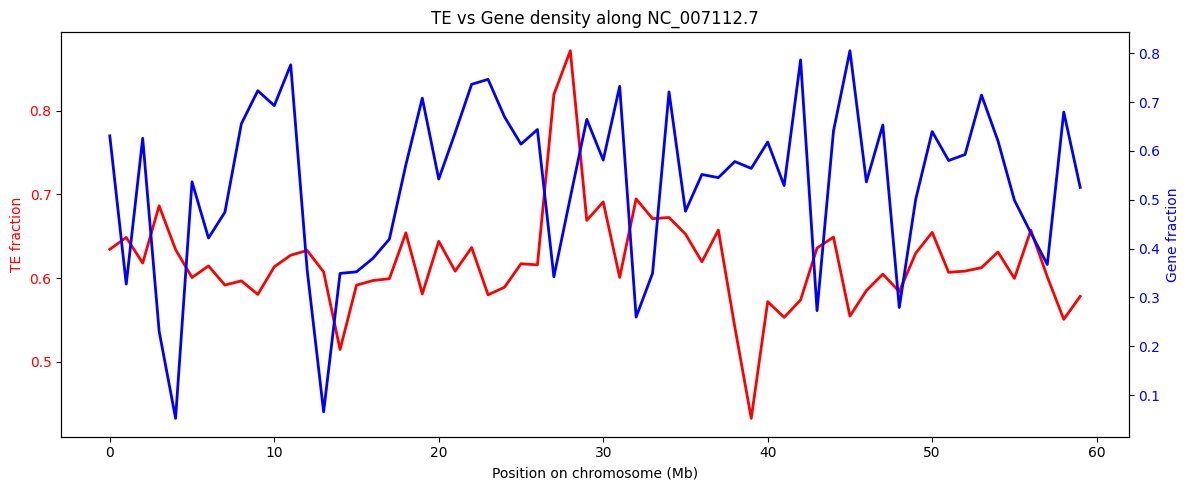

In [14]:
# Plot gene density vs TE density for a chromosome
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"

# Load both datasets
dfw_te = pd.read_csv("Danio_rerio_TE_density_1Mb.tsv", sep="\t")
dfw_genes = pd.read_csv("Danio_rerio_gene_density_1Mb.tsv", sep="\t")

# Filter for one chromosome
te_chr = dfw_te[dfw_te["chrom"] == chr_id].sort_values("window_start")
gene_chr = dfw_genes[dfw_genes["chrom"] == chr_id].sort_values("window_start")

# Plot both on same axes
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(te_chr["window_start"] / 1e6, te_chr["te_fraction"], 
         color='red', label='TE fraction', linewidth=2)
ax1.set_xlabel("Position on chromosome (Mb)")
ax1.set_ylabel("TE fraction", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(gene_chr["window_start"] / 1e6, gene_chr["gene_fraction"], 
         color='blue', label='Gene fraction', linewidth=2)
ax2.set_ylabel("Gene fraction", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"TE vs Gene density along {chr_id}")
fig.tight_layout()
plt.show()

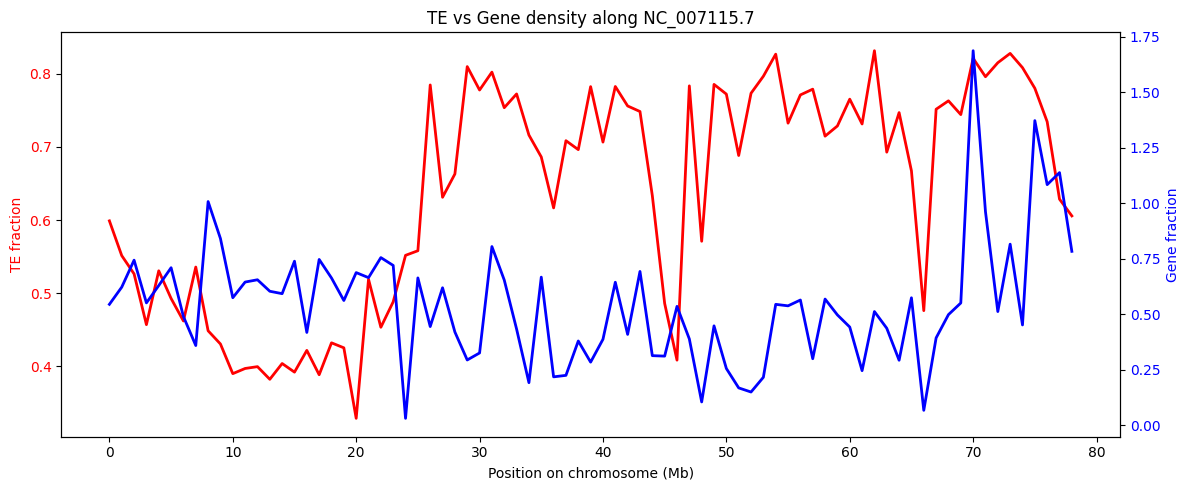

In [17]:
# Plot gene density vs TE density for a chromosome
import matplotlib.pyplot as plt

chr_id = "NC_007115.7"

# Load both datasets
dfw_te = pd.read_csv("Danio_rerio_TE_density_1Mb.tsv", sep="\t")
dfw_genes = pd.read_csv("Danio_rerio_gene_density_1Mb.tsv", sep="\t")

# Filter for one chromosome
te_chr = dfw_te[dfw_te["chrom"] == chr_id].sort_values("window_start")
gene_chr = dfw_genes[dfw_genes["chrom"] == chr_id].sort_values("window_start")

# Plot both on same axes
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(te_chr["window_start"] / 1e6, te_chr["te_fraction"], 
         color='red', label='TE fraction', linewidth=2)
ax1.set_xlabel("Position on chromosome (Mb)")
ax1.set_ylabel("TE fraction", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(gene_chr["window_start"] / 1e6, gene_chr["gene_fraction"], 
         color='blue', label='Gene fraction', linewidth=2)
ax2.set_ylabel("Gene fraction", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"TE vs Gene density along {chr_id}")
fig.tight_layout()
plt.show()